Julia notebook kernel

# CUDA

- https://docs.juliahub.com/CUDA/oWw5k/2.2.1/development/troubleshooting/
- https://github.com/JuliaGPU/KernelAbstractions.jl
  + https://juliagpu.github.io/KernelAbstractions.jl/dev/

# Wave equation 2d

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2}(x,y,t) - \left( \frac{\partial^2 u}{\partial x^2}(x,y,t) + \frac{\partial^2 u}{\partial y^2}(x,y,t) \right) = 0
\end{equation}
$$

Source: https://beltoforion.de/en/recreational_mathematics/2d-wave-equation.php

Also source: https://elar.urfu.ru/bitstream/10995/31219/1/978-5-7996-1342-6_2014.pdf
В. Г. Пименов, А. Б. Ложников ЧИСЛЕННЫЕ МЕТОДЫ В двух частях Часть 2 2014г. стр 87

TODO: absorbing boundary condition https://encyclopediaofmath.org/wiki/Absorbing_boundary_conditions

$$
\partial_t^2 u = \Delta u = \nabla^2 u
$$

The discrete version
$$
\begin{equation}
\partial_t^2 u^{(1)}_{i,j} = \frac{u^{(0)}_{i,j} - 2 u^{(1)}_{i,j} + u^{(2)}_{i,j}}{\tau^2}
\end{equation}
$$

The discrete version of the two-dimensional Laplace operator
$$
\begin{equation}		
		\quad \mathbf{D}^2_{i,j}=\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}
\end{equation}
$$
$$
\begin{equation}
	\Delta u^{(1)}_{i,j} = \frac{u^{(1)}_{i-1,j}+u^{(1)}_{i+1,j}+u^{(1)}_{i,j-1}+u^{(1)}_{i,j+1} - 4 u^{(1)}_{i,j}}{h^2}
\end{equation}
$$

Solution is
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( u^{(k)}_{i-1,j}+u^{(k)}_{i+1,j}+u^{(k)}_{i,j-1}+u^{(k)}_{i,j+1} - 4 u^{(k)}_{i,j} \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( \mathbf{D}^2_{i,j} u \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$

In [1]:
const τ = 0.003
const h = 0.01
@assert (τ/h)^2 <= 1 # * условие сходимости


In [2]:
 # * начальные условия
@inline fn(x) = x^2 < 1 ? -x^2 + 1 : 0

@inline ϕ(x, y) = fn(16 * ((x - 1 / 2)^2 + (y - 1 / 2)^2))
@inline ψ(x, y) = 0

ψ (generic function with 1 method)

In [3]:
import Plots
Plots.gr()

function plot3d(data; zlims)
  (x, y, u_xy) = data
  Plots.surface(x, y, u_xy; size=(1000, 1000), zlims=zlims, clims=zlims)
end

fps = 2
function gif(arr, iter)
  anim = Plots.@animate for i in arr
    iter(i)
  end

  Plots.gif(anim, "tmp.gif", fps = fps)
end

function anim(u, iter; maxN=100, maxNt=4fps)
  Nt = size(u)[end]
  mt = div(Nt,maxNt)
  t = 1:mt:Nt

  m = div(N, maxN)
  x = xx[1:m:end]
  y = yy[1:m:end]

  gif(t, k -> begin
    u_xy = u[1:m:end, 1:m:end, k]
    data = (x, y, u_xy)
    iter(data)
  end)
end

anim (generic function with 1 method)

In [4]:
import CUDA as cu
import CUDA: CuArray, @cuda

function gpu_grid_idx()
  block_dim = cu.blockDim().x

  thread_idx = cu.threadIdx().x
  block_idx = cu.blockIdx().x
  grid_idx = (block_idx - 1) * block_dim + thread_idx;

  return grid_idx
end
function gpu_grid_dim()
  grid_dim = cu.gridDim().x * cu.blockDim().x
  return grid_dim
end

cumaxdim = cu.attribute(cu.device(), cu.DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X)

1024

#### Use more accurate spatial derivatives

$O(h^4)$:
$$
\begin{equation}
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{12}\begin{bmatrix}0 & 0 & -1 & 0 & 0\\0 & 0 & 16 & 0 & 0\\-1 & 16 & -60 & 16 & -1\\0 & 0 & 16 & 0 & 0\\0 & 0 & -1 & 0 & 0\end{bmatrix}
\end{equation}
$$

$O(h^6)$:
$$
\begin{equation}		
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{180}\begin{bmatrix}0 & 0 & 0 & 2 & 0 & 0 & 0\\0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 270 & 0 & 0 & 0\\2 & -27 & 270 & -980 & 270 & -27 & 2\\ 0 & 0 & 0 & 270 & 0 & 0 & 0\\ 0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 2 & 0 & 0 & 0\end{bmatrix}
\end{equation}
$$

A version of the difference equation with a location derivative term of error order $O(h^4)$ looks like this:
$$
\begin{equation}
	u^{(0)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left(-u^{(1)}_{i,j-2}+16u^{(1)}_{i,j-1}-u^{(1)}_{i-2,j}+16u^{(1)}_{i-1,j}-60u^{(1)}_{i,j}+16u^{(1)}_{i+1,j}-u^{(1)}_{i+2,j}+16u^{(1)}_{i,j+1}-u^{(1)}_{i,j+2}  \right) + 2 u^{(1)}_{i,j} -  u^{(2)}_{i,j}
\end{equation}
$$

Начальнаые условия:
$$
\partial_t^2 u - \partial_x^2 u - \partial_y^2 u= 0
$$
$$
u(0,x,y) = \phi(x,y), \,\,\, \partial_t u |_{t=0} = \psi(x, y)
$$

In [5]:
const x_start = -4
const x_end = 4
xx = CuArray(x_start:h:x_end)
yy = xx
@show const N = length(xx)

function gpu_set_initial_layers!(u)
  x = (i) -> x_start + i * h
  y = (j) -> x(j)

  idx = gpu_grid_idx()
  dim = gpu_grid_dim()

  for i in idx:dim:N
    for j in 1:N
      @inbounds u[i, j, 1] = ϕ(x(i), y(j))
      @inbounds u[i, j, 2] = u[i, j, 1] + τ * ψ(x(i), y(j))
    end
  end

  return nothing
end

function gpu_calc_next_layer!(u, k)
  at = (i, j) -> begin
    val::Float32 = 0
    # * нулевые заграничные условия
    if i < 1 || i > N || j < 1 || j > N
      return val
    end
    val = u[i, j, k]
    return val
  end
  D2_h2 = (i, j) -> at(i - 1, j) + at(i + 1, j) + at(i, j - 1) + at(i, j + 1) - 4 * at(i, j)
  d2 = D2_h2

  idx = gpu_grid_idx()
  dim = gpu_grid_dim()

  σ = (τ / h)^2
  for i in idx:dim:N
    for j in 1:N
      d2_ij = d2(i, j)
      @inbounds u[i, j, k+1] = -u[i, j, k-1] + 2 * u[i, j, k] + σ * d2_ij
    end
  end
  return nothing
end

function solve(; T=1)
  tt = CuArray(0:τ:T)
  Nt = length(tt)

  u = cu.zeros(N, N, Nt)
  
  numblocks = ceil(Int, N / cumaxdim)

  println("gpu_set_initial_layers!")
  @time begin
    @cuda threads = cumaxdim blocks = numblocks gpu_set_initial_layers!(u)
    cu.synchronize()
  end

  println("iterations")
  @time for k in 2:Nt-1
    @cuda threads = cumaxdim blocks = numblocks gpu_calc_next_layer!(u, k)
    cu.synchronize()
  end

  u
end

const N = length(xx) = 801


solve (generic function with 1 method)

gpu_set_initial_layers!
  9.952260 seconds (17.96 M allocations: 924.937 MiB, 3.30% gc time, 19.09% compilation time)
iterations
  2.960933 seconds (1.46 M allocations: 78.109 MiB, 0.62% gc time, 5.71% compilation time)
anim


┌ Warning: Performing scalar indexing on task Task (runnable) @0x0000025fea0a07d0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore C:\Users\User\.julia\packages\GPUArraysCore\B3xv7\src\GPUArraysCore.jl:103


 23.377956 seconds (43.44 M allocations: 2.367 GiB, 6.06% gc time, 58.97% compilation time)


[ Info: Saved animation to d:\_docs\__math\__julia\src\samples\tmp.gif


Plots.AnimatedGif("d:\\_docs\\__math\\__julia\\src\\samples\\tmp.gif")
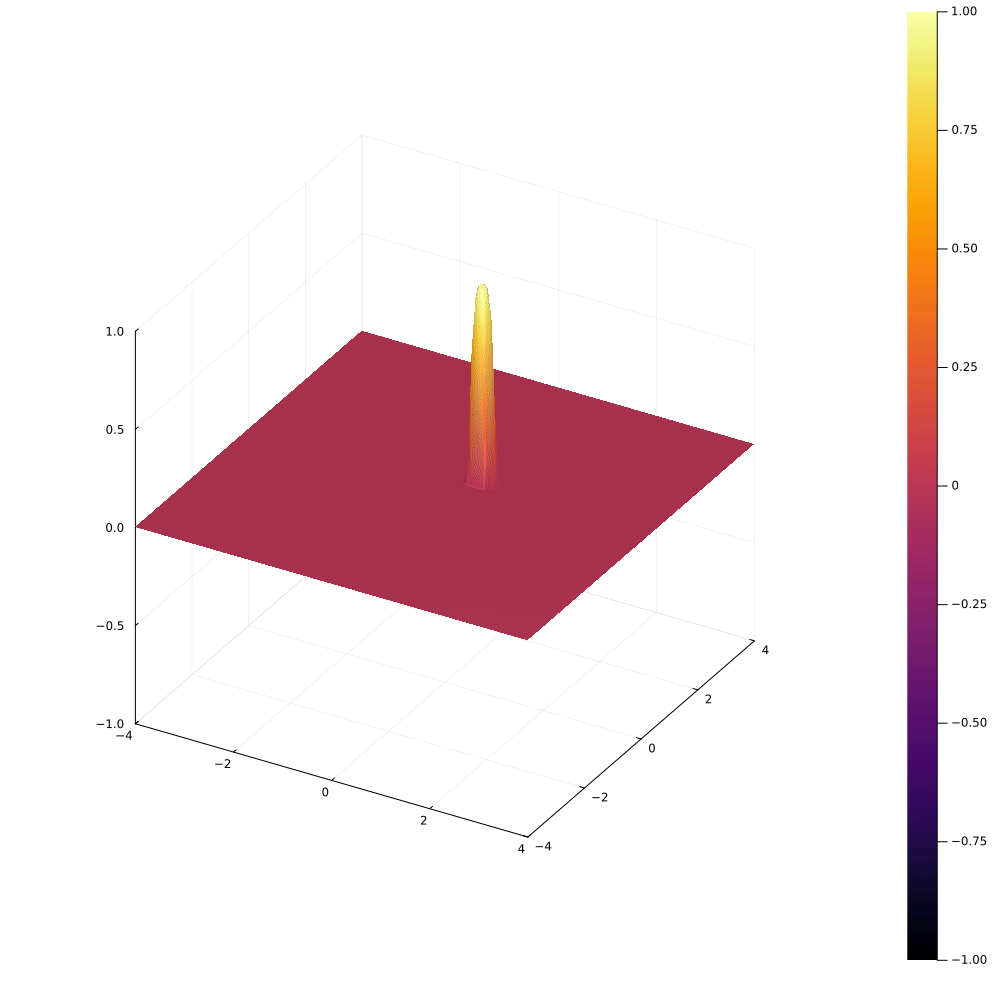

In [6]:
let
  u = solve(; T = 1)

  println("anim")
  @time plot = anim(u, data -> plot3d(data; zlims=(-1.0,1)))
  plot
end